# use another position
- initial_state2, 2nd last is flipped
- has 2 circuits instead of 3 circuits.  11/16/2022
- integrate early termination if obj does not change for 5 iterations.
- use structure3: replace CZ in struct2 by CNOT here

In [1]:
# !pip install pennylane
# !pip install pennylane-qiskit

In [2]:
# !pip install pennylane-lightning

In [3]:
# !pip install pennylane-lightning[gpu]  # has erro

In [4]:
import numpy as np
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as qml_np
import pennylane as qml

import math
import matplotlib.pyplot as plt
import datetime

# 2nd last flipped

In [5]:
num_of_qubits = 1+15
eps_val_q = 1/math.sqrt(2**num_of_qubits)/100
eps_val = min(1e-10, eps_val_q)
tiny_change_threshold = 1e-4
cnt_threshold_no_change = 5

N = 2**(num_of_qubits-2)
normal_val = math.sqrt(1/N)
# initial_state_phi1 = [math.sqrt(1/N)]*(N-1) + [0]*N + [math.sqrt(1/N)] # 2**(num_of_qubits-1)
# initial_state_phi1 = [.5,.5,.5, 0,   0, 0, 0, .5,  ] # 2**(num_of_qubits-1)

initial_state2 = [1/math.sqrt(N)]*(N-2) + [0, 1/math.sqrt(N)] + [0]*(N-2) + [1/math.sqrt(N), 0] # 2**(num_qubits-1)
initial_state_phi1 = initial_state2
print(f'initial_state_phi1={initial_state_phi1}')
# print(f'initial_state_phi1={initial_state_phi1[-5:]}')
initial_state_0_phi1  = initial_state_phi1 + [0]*len(initial_state_phi1) # 2**num_of_qubits


# print(f'initial_state3={initial_state3}')
# initial_state  = initial_state3 + [0]*len(initial_state3) # 2**num_qubits

initial_state_phi1=[0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0

In [6]:
print(np.arange(1,10, 3))
print(np.linspace(1,10, 4))
print(list(range(10)))

[1 4 7]
[ 1.  4.  7. 10.]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [7]:
device_name = 'default.qubit'  #'default.qubit' # 
device_name2 = 'default.qubit' # has qml.state()

In [8]:


def layer_t3_no_HT(theta, qubit_posi):
    # type-2 layer
    # length of theta: (num_of_qubits-1)*2
    # length of qubit_posi: num_of_qubits-1
    # number of wires: num_of_qubits
    for i in range(num_of_qubits-1):
        qml.RY(theta[i], wires=(qubit_posi[i]))    
    for i in np.arange(0, num_of_qubits-2, 2):
#         qml.ctrl(qml.PauliZ(qubit_posi[i+1]), qubit_posi[i]) # CZ struct2
        qml.CNOT(wires=(qubit_posi[i],qubit_posi[i+1])) # CNOT struct3
    for i in range(num_of_qubits-1):
        qml.RY(theta[i+num_of_qubits-1], wires=(qubit_posi[i]))
    for i in np.arange(1, num_of_qubits-2, 2):
#         qml.ctrl(qml.PauliZ(qubit_posi[i+1]), qubit_posi[i]) # CZ struct2
        qml.CNOT(wires=(qubit_posi[i],qubit_posi[i+1])) # CNOT struct3
#     qml.ctrl(qml.PauliZ(qubit_posi[0]), qubit_posi[-1]) # CZ struct2
    qml.CNOT(wires=(qubit_posi[-1],qubit_posi[0])) # CNOT struct3
        
def layer_t3_with_HT(theta, num_of_qubits):
    # type-2 layer
    # length of theta: (num_of_qubits-1)*2
    # number of wires: num_of_qubits
    for i in range(num_of_qubits-1):
        qml.CRY(theta[i], wires=(0, i+1))    
    for i in np.arange(0, num_of_qubits-2, 2):
#         qml.ctrl(qml.PauliZ(i+2), (0, i+1)) # CZ struct2
        qml.Toffoli(wires=(0,i+1,i+2)) # CCNOT struct3
        
    for i in range(num_of_qubits-1):
        qml.CRY(theta[i+num_of_qubits-1], wires=(0, i+1))
    for i in np.arange(1, num_of_qubits-2, 2):
#         qml.ctrl(qml.PauliZ(i+2), (0, i+1)) # CZ struct2
        qml.Toffoli(wires=(0,i+1,i+2)) # CCNOT struct3
#     qml.ctrl(qml.PauliZ(1), (0, num_of_qubits-1)) # CZ struct2
    qml.Toffoli(wires=(0,num_of_qubits-1, 1)) # CCNOT struct3
    
test_flag = False  # True # False
if test_flag:
    for num_of_qubits in [10, 11]:   # 10 or 11 for the test below
        print('num_of_qubits=', num_of_qubits)
        dev_with_HT=qml.device(device_name, wires=num_of_qubits)
        @qml.qnode(dev_with_HT)
        def quantum_circuit_test3(theta):
            qubit_posi = list(range(math.floor(len(theta)/2)))
            layer_t3_no_HT(theta, qubit_posi)
            # length of theta: (num_of_qubits-1)*2
            # number of wires: num_of_qubits
            return qml.expval(qml.PauliZ(0))

        dev_with_HT=qml.device(device_name, wires=num_of_qubits)
        @qml.qnode(dev_with_HT)
        def quantum_circuit_test4(theta):
            qubit_posi = list(range(math.floor(len(theta)/2)))
            layer_t3_with_HT(theta, num_of_qubits)
            # length of theta: (num_of_qubits-1)*2
            # number of wires: num_of_qubits
            return qml.expval(qml.PauliZ(0))

        if num_of_qubits == 10:
            theta = [1,2,3,4,5,6,7,8,9,  1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1]
            test1_val = quantum_circuit_test3(theta)
            print(qml.draw(quantum_circuit_test3)(theta))
            print('test3_val=', test1_val)

            theta = [1,2,3,4,5,6,7,8,9,  1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1]
            test1_val = quantum_circuit_test4(theta)
            print(qml.draw(quantum_circuit_test4)(theta))
            print('test4_val=', test1_val)

        if num_of_qubits == 11:
            theta = [1,2,3,4,5,6,7,8,9,10,  1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1,10.1]
            test1_val = quantum_circuit_test3(theta)
            print(qml.draw(quantum_circuit_test3)(theta))
            print('test3_val=', test1_val)

            theta = [1,2,3,4,5,6,7,8,9,10,  1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1,10.1]
            test1_val = quantum_circuit_test4(theta)
            print(qml.draw(quantum_circuit_test4)(theta))
            print('test4_val=', test1_val)


In [9]:
     
# dev_with_HT=qml.device(device_name2, wires=num_of_qubits+1) #AerDevice(wires=num_of_qubits, shots=20000, backend='qasm_simulator')
dev_with_HT=qml.device(device_name, wires=num_of_qubits)
@qml.qnode(dev_with_HT)
def quantum_circuit_with_HT(theta):
    # initiate state vector |phi_1>
    qml.QubitStateVector(np.array(initial_state_0_phi1), wires=range(num_of_qubits))
#     qubit_position = list(range(1,num_of_qubits))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_of_qubits)
    qml.Hadamard(0)
    for theta_i in theta:
        layer_t3_with_HT(theta_i, num_of_qubits)
    qml.Hadamard(0)    
    return qml.expval(qml.PauliZ(0)) 
    # return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
print(qml.draw(quantum_circuit_with_HT)([[0.1]*2*(num_of_qubits-1)]))
# print(quantum_circuit_with_HT([[0.1]*(num_of_qubits-1)]))




 0: ─╭QubitStateVector(M0)──H─╭●────────╭●────────╭●────────╭●────────╭●────────╭●────────╭●───────
 1: ─├QubitStateVector(M0)────╰RY(0.10)─│─────────│─────────│─────────│─────────│─────────│────────
 2: ─├QubitStateVector(M0)──────────────╰RY(0.10)─│─────────│─────────│─────────│─────────│────────
 3: ─├QubitStateVector(M0)────────────────────────╰RY(0.10)─│─────────│─────────│─────────│────────
 4: ─├QubitStateVector(M0)──────────────────────────────────╰RY(0.10)─│─────────│─────────│────────
 5: ─├QubitStateVector(M0)────────────────────────────────────────────╰RY(0.10)─│─────────│────────
 6: ─├QubitStateVector(M0)──────────────────────────────────────────────────────╰RY(0.10)─│────────
 7: ─├QubitStateVector(M0)────────────────────────────────────────────────────────────────╰RY(0.10)
 8: ─├QubitStateVector(M0)─────────────────────────────────────────────────────────────────────────
 9: ─├QubitStateVector(M0)─────────────────────────────────────────────────────────────────────────


In [10]:

# dev_with_HTZ=qml.device(device_name2, wires=num_of_qubits+1) #AerDevice(wires=num_of_qubits, shots=20000, backend='qasm_simulator')
dev_with_HTZ=qml.device(device_name, wires=num_of_qubits)
@qml.qnode(dev_with_HTZ)
def quantum_circuit_with_HTZ(theta):
    # initiate state vector |phi_1>
    qml.QubitStateVector(np.array(initial_state_0_phi1), wires=range(num_of_qubits))
#     qubit_position = list(range(1,num_of_qubits))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_of_qubits)
    qml.Hadamard(0)
    for theta_i in theta:
        layer_t3_with_HT(theta_i, num_of_qubits)
    qml.CZ([0,1])
    qml.Hadamard(0)    
    return qml.expval(qml.PauliZ(0)) 
    # return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
print('newly added')
print(qml.draw(quantum_circuit_with_HTZ)([[0.1]*2*(num_of_qubits-1)]))
# print(quantum_circuit_with_HTZ([[0.1]*(num_of_qubits-1)]))



# dev_no_HT_Z=qml.device(device_name2, wires=num_of_qubits+1) #AerDevice(wires=num_of_qubits-1, shots=20000, backend='qasm_simulator')
dev_no_HT_Z=qml.device(device_name, wires=num_of_qubits-1)        
@qml.qnode(dev_no_HT_Z)
def quantum_circuit_no_HT_return_Z(theta):
    # initiate state vector |phi_1>
    qml.QubitStateVector(np.array(initial_state_phi1), wires=range(num_of_qubits-1))
#     qubit_position = list(range(num_of_qubits-1))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_of_qubits-1)
    for theta_i in theta:
        layer_t3_no_HT(theta_i, list(range(num_of_qubits-1)))
    
    return qml.expval(qml.PauliZ(0))  
    # return qml.sample(qml.PauliZ(0)) 
print('newly added 2')   
print(qml.draw(quantum_circuit_no_HT_return_Z)([[0.2]*2*(num_of_qubits-1)]))
# print(quantum_circuit_with_HT([[0.2]*(num_of_qubits-1)]))


# dev_no_HT_S=qml.device(device_name2, wires=num_of_qubits+1) #AerDevice(wires=num_of_qubits-1, backend='qasm_simulator')
dev_no_HT_S=qml.device(device_name2, wires=num_of_qubits-1)  
@qml.qnode(dev_no_HT_S)
def quantum_circuit_no_HT_return_state(theta):
    # initiate state vector |phi_1>
    qml.QubitStateVector(np.array(initial_state_phi1), wires=range(num_of_qubits-1))
#     qubit_position = list(range(num_of_qubits-1))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_of_qubits-1)
    for theta_i in theta:
        layer_t3_no_HT(theta_i, list(range(num_of_qubits-1)))    
    return qml.state()

print('newly added 3')

newly added
 0: ─╭QubitStateVector(M0)──H─╭●────────╭●────────╭●────────╭●────────╭●────────╭●────────╭●───────
 1: ─├QubitStateVector(M0)────╰RY(0.10)─│─────────│─────────│─────────│─────────│─────────│────────
 2: ─├QubitStateVector(M0)──────────────╰RY(0.10)─│─────────│─────────│─────────│─────────│────────
 3: ─├QubitStateVector(M0)────────────────────────╰RY(0.10)─│─────────│─────────│─────────│────────
 4: ─├QubitStateVector(M0)──────────────────────────────────╰RY(0.10)─│─────────│─────────│────────
 5: ─├QubitStateVector(M0)────────────────────────────────────────────╰RY(0.10)─│─────────│────────
 6: ─├QubitStateVector(M0)──────────────────────────────────────────────────────╰RY(0.10)─│────────
 7: ─├QubitStateVector(M0)────────────────────────────────────────────────────────────────╰RY(0.10)
 8: ─├QubitStateVector(M0)─────────────────────────────────────────────────────────────────────────
 9: ─├QubitStateVector(M0)──────────────────────────────────────────────────────────────

In [11]:

val_global = []
coef2 = 1
def objective_fn(theta):
    global val_global
    val1_1 = quantum_circuit_with_HT(theta)
    val1_2 = quantum_circuit_with_HTZ(theta)
    val1_1 = val1_1/normal_val
    val1_2 = val1_2/normal_val
#     val2 = quantum_circuit_no_HT_return_Z(theta)
#     return coef2*val2-0.5*(val1_1 - val1_2)
    obj = -0.5*(val1_1 - val1_2)
    val_global.append([val1_1._value.tolist(), val1_2._value.tolist(), obj._value.tolist()])
    return obj


## 3 layers

In [12]:
max_repeat = 100 #100
iter_max = 300  #300
num_of_layers = 3
prb_last_list = []
obj_list_rep = []
theta_list = []
iter_terminate_list = []
debug_flag, print_flag = 0, True
start_time = datetime.datetime.now()
for rep in range(1,max_repeat+1):
    if print_flag:
        print(f'\n\nrep={rep}')
    else:
        print(f'\n\nrep={rep}', end='  ')
    
    optimizer = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)
    theta=qml_np.random.uniform(0, 2*math.pi, size=(num_of_layers, 2*(num_of_qubits-1)), requires_grad=True)
    obj_list = []
    tiny_change_cnt = 0
    break_flag = False
    iter_terminate=iter_max
    for iter in range(1, iter_max+1):    
        theta, obj = optimizer.step_and_cost(objective_fn, theta)
#         val1_1 = quantum_circuit_with_HT(theta)
#         val1_2 = quantum_circuit_with_HTZ(theta)
#         val2 = quantum_circuit_no_HT_return_Z(theta)
        val1_1 = val_global[-1][0]
        val1_2 = val_global[-1][1]
#         val2 = val_global[-1][2]
        if iter>=2:
            val1_1_old = val_global[-2][0]
            val1_2_old = val_global[-2][1]
            #val2_old = val_global[-2][2]
        else:
            val1_1_old = 999
            val1_2_old = 999
            #val2_old = 999
        val1 = val1_1 - val1_2
        val1_old = val1_1_old - val1_2_old
        if abs(val1) > eps_val: # eps_val=1e-10
            if abs( (val1-val1_old)/val1 ) < tiny_change_threshold: # 1e-3
                tiny_change_cnt += 1
            else:
                tiny_change_cnt = 0
        if tiny_change_cnt >= cnt_threshold_no_change: # no change for a consequtive of 5 iterations, then break
            break_flag = True
        if (iter==1 or iter%20==0 or iter==iter_max) and print_flag:
            print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
                 :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}  \
                 :: theta={theta}')
#             print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
#                  :: val1_2={val1_2:12.8f} :: val2={val2:12.8f}  \
#                  coef2*val2-0.5*(val1_1 - val1_2)={coef2*val2-0.5*(val1_1 - val1_2):12.8f}  \
#                  :: theta={theta}')
            # print(f'iter={iter:3d} :: obj={obj:12.8f} :: theta={theta}')
        obj_list.append(obj)
        if break_flag:
            iter_terminate=iter
            break
    theta_list.append(theta)
    print(f'obj_list(last 3)={obj_list[-3:]}')
    obj_list_rep.append(obj_list)
    
    end_time = datetime.datetime.now()
    duration = end_time - start_time
    duration_in_s = duration.total_seconds()
    print(f'time consumed: {duration_in_s}s, after for-iter')
    
    print('val_global=')
    print(val_global)
    val_global = [] # reset to empty
    
    ## display the amplified state
    state = quantum_circuit_no_HT_return_state(theta)
    prb = [i.item()**2 for i in state]
    # print(f'state={state}')
    if len(prb)>20:
        print(f'prb(last 2)={prb[-2:]}')
    else: print(f'prb={prb}')
    iter_terminate_list.append(iter_terminate)
    prb_last_list.append(prb[-2])
# print('theta_list=', theta_list)
# print('iter_terminate_list=', iter_terminate_list)
# print('prb_last_list=', prb_last_list)
end_time = datetime.datetime.now()
duration = end_time - start_time
duration_in_s = duration.total_seconds()
print(f'time consumed: {duration_in_s}s')



rep=1
iter=  1 :: obj= -0.00223277 :: val1_1= -0.54376831                  :: val1_2= -0.54823384 :: -0.5*(val1_1 - val1_2)= -0.00223277                   :: theta=[[0.16164457 0.19051709 2.6168115  1.30126412 4.35774591 3.64341395
  2.0808617  6.18137095 2.8013456  4.47782    0.08537991 0.42451885
  5.46365667 3.33724322 3.10834702 5.57481275 5.83727126 4.24455777
  2.11839187 5.82187176 2.17750312 1.44393993 2.87369654 0.29751035
  1.19663238 2.28021494 0.05342763 1.1494866  4.8783812  3.56575796]
 [4.15657621 4.54866504 4.26038228 3.76617656 4.72747112 0.20129935
  3.77145453 5.11228313 3.07267218 3.65066721 2.46095572 1.6154654
  4.98723965 3.76553703 0.94033971 0.16826068 1.4573109  1.16225076
  1.92288605 0.60012705 4.00922236 5.51467271 3.1393413  1.41938885
  4.75659093 3.2070575  4.06231926 4.86390058 5.23397849 5.26386952]
 [5.86529636 3.71127253 6.19015577 4.31565554 4.2191163  0.96319137
  3.80780847 2.34894139 5.85606241 0.97935998 5.54223799 2.3447085
  5.32439449 2.364

In [13]:
print('theta_list=', theta_list)
print('iter_terminate_list=', iter_terminate_list)
print('prb_last_list=', prb_last_list)

theta_list= [tensor([[ 0.38230849, -0.11462666,  1.60409876,  1.40396991,  5.13513806,
          3.1557848 ,  2.34333372,  6.52513064,  1.51808814,  4.74039389,
         -1.0525658 ,  0.55198723,  6.14395422,  3.09703907,  2.92464064,
          5.74908619,  5.46320138,  4.3254649 ,  2.63598336,  5.04470973,
          1.54042884,  1.53197882,  2.43564916,  0.1461344 ,  0.71394768,
          2.770903  ,  1.01275576,  0.3965103 ,  5.28180692,  3.38205159],
        [ 4.36770265,  4.22121313,  4.6264091 ,  4.22156344,  4.624268  ,
          0.63782932,  3.71825483,  4.56261249,  4.17638153,  4.27198835,
          1.59953972,  1.54681584,  4.74331255,  4.23864462,  0.73499305,
          1.71504382,  1.54476183,  0.84156465,  1.60537233,  1.36537421,
          3.76595279,  5.94371918,  1.81992475,  1.54510212,  4.73183861,
          2.20941099,  4.6569575 ,  4.66398728,  4.80584279,  5.05852287],
        [ 5.47181443,  4.42130172,  5.66207072,  4.78255241,  4.48751818,
          1.17516347,  

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,
         0.,  2.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,
         0.,  6.,  0.,  0.,  7.,  0.,  0.,  5.,  0.,  0.,  6.,  0.,  0.,
         9.,  0.,  0.,  9.,  0.,  0., 12.,  0.,  0.,  0.,  7.,  0.,  0.,
         4.,  0.,  0.,  8.,  0.,  0.,  2.,  0.,  0.,  3.,  0.,  0.,  7.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([47.  , 47.32, 47.64, 47.96, 48.28, 48.6 , 48.92, 49.24, 49.56,
        49.88, 50.2 , 50.52, 50.84, 51.16, 51.48, 51.8 , 52.12, 52.44,
        52.76, 53.08, 53.4 , 53.72, 54.04, 54.36, 54.68, 55.  , 55.32,
        55.64, 55.96, 56.28, 56.6 , 56.92, 57.24, 57.56, 57.88, 58.2 ,
        58.52, 58.84, 59.16, 59.48, 59.8 , 60.12, 60.44, 60.76, 61.08,
        61.4 , 61.72, 62.04, 62.36, 62.68, 63.  , 63.32, 63.64, 63.96,
        

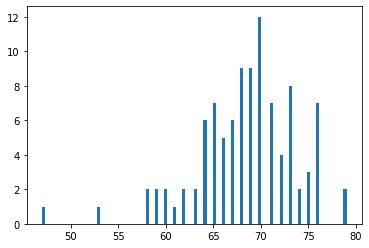

In [14]:
plt.hist(iter_terminate_list,100)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  1.,  2.,  1.,  1.,  0.,  2.,  0.,  0.,
         1.,  1.,  2.,  2.,  0.,  2.,  4.,  3.,  3.,  9.,  8.,  8.,  2.,
         5.,  2.,  9.,  4., 11.,  3.,  3.,  0.,  1.]),
 array([0.99296208, 0.99302713, 0.99309219, 0.99315724, 0.99322229,
        0.99328735, 0.9933524 , 0.99341745, 0.9934825 , 0.99354756,
        0.99361261, 0.99367766, 0.99374271, 0.99380777, 0.99387282,
        0.99393787, 0.99400292, 0.99406798, 0.99413303, 0.99419808,
        0.99426314, 0.99432819, 0.99439324, 0.99445829, 0.99452335,
        0.9945884 , 0.99465345, 0.9947185 , 0.99478356, 0.99484861,
        0.99491366, 0.9949

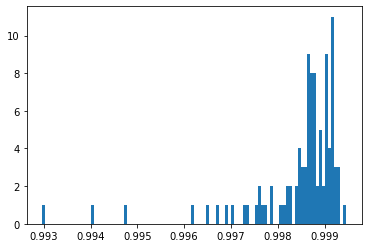

In [15]:
prb_last_list_real = [i.real for i in prb_last_list]
plt.hist(prb_last_list_real,100)

In [16]:
print('time now: ', end_time)

time now:  2022-11-27 06:41:18.830284


## 2 layers

In [17]:
max_repeat = 100 #100
iter_max = 300  #300
num_of_layers = 2
prb_last_list = []
obj_list_rep = []
theta_list = []
iter_terminate_list = []
debug_flag, print_flag = 0, True
start_time = datetime.datetime.now()
for rep in range(1,max_repeat+1):
    if print_flag:
        print(f'\n\nrep={rep}')
    else:
        print(f'\n\nrep={rep}', end='  ')
    
    optimizer = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)
    theta=qml_np.random.uniform(0, 2*math.pi, size=(num_of_layers, 2*(num_of_qubits-1)), requires_grad=True)
    obj_list = []
    tiny_change_cnt = 0
    break_flag = False
    iter_terminate=iter_max
    for iter in range(1, iter_max+1):    
        theta, obj = optimizer.step_and_cost(objective_fn, theta)
#         val1_1 = quantum_circuit_with_HT(theta)
#         val1_2 = quantum_circuit_with_HTZ(theta)
#         val2 = quantum_circuit_no_HT_return_Z(theta)
        val1_1 = val_global[-1][0]
        val1_2 = val_global[-1][1]
#         val2 = val_global[-1][2]
        if iter>=2:
            val1_1_old = val_global[-2][0]
            val1_2_old = val_global[-2][1]
            val2_old = val_global[-2][2]
        else:
            val1_1_old = 999
            val1_2_old = 999
            val2_old = 999
        val1 = val1_1 - val1_2
        val1_old = val1_1_old - val1_2_old
        if abs(val1) > eps_val: # eps_val=1e-10
            if abs( (val1-val1_old)/val1 ) < tiny_change_threshold: # 1e-3
                tiny_change_cnt += 1
            else:
                tiny_change_cnt = 0
        if tiny_change_cnt >= cnt_threshold_no_change: # no change for a consequtive of 5 iterations, then break
            break_flag = True
        if (iter==1 or iter%20==0 or iter==iter_max) and print_flag:
            print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
                 :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}  \
                 :: theta={theta}')
#             print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
#                  :: val1_2={val1_2:12.8f} :: val2={val2:12.8f}  \
#                  coef2*val2-0.5*(val1_1 - val1_2)={coef2*val2-0.5*(val1_1 - val1_2):12.8f}  \
#                  :: theta={theta}')
            # print(f'iter={iter:3d} :: obj={obj:12.8f} :: theta={theta}')
        obj_list.append(obj)
        if break_flag:
            iter_terminate=iter
            break
    theta_list.append(theta)
    print(f'obj_list(last 3)={obj_list[-3:]}')
    obj_list_rep.append(obj_list)
    
    end_time = datetime.datetime.now()
    duration = end_time - start_time
    duration_in_s = duration.total_seconds()
    print(f'time consumed: {duration_in_s}s, after for-iter')
    
    print('val_global=')
    print(val_global)
    val_global = [] # reset to empty
    
    ## display the amplified state
    state = quantum_circuit_no_HT_return_state(theta)
    prb = [i.item()**2 for i in state]
    # print(f'state={state}')
    if len(prb)>20:
        print(f'prb(last 2)={prb[-2:]}')
    else: print(f'prb={prb}')
    iter_terminate_list.append(iter_terminate)
    prb_last_list.append(prb[-2])
# print('theta_list=', theta_list)
# print('iter_terminate_list=', iter_terminate_list)
# print('prb_last_list=', prb_last_list)
end_time = datetime.datetime.now()
duration = end_time - start_time
duration_in_s = duration.total_seconds()
print(f'time consumed: {duration_in_s}s')



rep=1
iter=  1 :: obj= -0.00236826 :: val1_1= -0.03552508                  :: val1_2= -0.04026160 :: -0.5*(val1_1 - val1_2)= -0.00236826                   :: theta=[[1.23435021 0.28460378 1.97161735 3.06242333 5.07225155 3.59010958
  3.60760817 5.6999006  0.44229759 2.1678553  4.76923172 5.47312039
  1.47409708 1.46636619 6.1532262  5.758234   1.47117692 1.15601561
  5.31496546 4.16775855 3.30644925 4.92823842 2.23365381 4.23805433
  5.4609475  6.14924066 0.78298532 5.29440816 2.20607024 5.75261774]
 [1.28342033 0.14922307 4.82740311 4.74101378 4.76827381 4.16917007
  2.53730633 2.18659246 5.66810367 1.2354885  3.0476849  2.45754564
  2.93073054 2.25652172 4.89238672 4.82900987 2.28477311 1.4309948
  2.86939412 4.81627005 3.48115086 0.27196697 3.81171031 6.08834249
  5.60121069 4.19596199 3.89232318 2.8227449  3.26834559 2.71665035]]
iter= 20 :: obj= -0.87180738 :: val1_1=  1.44875650                  :: val1_2= -0.29485825 :: -0.5*(val1_1 - val1_2)= -0.87180738                   :: 

In [18]:
print('theta_list=', theta_list)
print('iter_terminate_list=', iter_terminate_list)
print('prb_last_list=', prb_last_list)

theta_list= [tensor([[ 1.66463261e+00, -1.80251922e-04,  1.73463489e+00,
          3.60300832e+00,  4.96825367e+00,  3.58709444e+00,
          4.17306285e+00,  6.28994919e+00, -1.49327473e-01,
          3.15033729e+00,  5.20621908e+00,  6.34357262e+00,
          1.40555255e+00,  1.74571920e+00,  6.48370704e+00,
          6.19354840e+00,  1.58591859e+00,  1.13534023e+00,
          5.17222993e+00,  5.21278388e+00,  2.23429798e+00,
          5.23753810e+00,  1.56381169e+00,  3.97934354e+00,
          4.71760937e+00,  6.74843895e+00,  1.51231338e+00,
          4.68599444e+00,  1.95290187e+00,  6.08309858e+00],
        [ 1.47775168e+00, -1.17459609e+00,  5.02969014e+00,
          4.78023101e+00,  5.09442165e+00,  5.11356140e+00,
          1.69687504e+00,  1.52448525e+00,  5.67926426e+00,
          1.08089034e+00,  2.66900787e+00,  1.59399186e+00,
          1.65986228e+00,  1.91053943e+00,  5.01335923e+00,
          6.38280577e+00,  1.95235279e+00,  2.24085996e+00,
          1.67655733e+00, 

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  4.,
         0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  2.,  0.,
         0.,  7.,  0.,  0., 10.,  0.,  0.,  8.,  0.,  0.,  8.,  0.,  0.,
         5.,  0.,  0.,  4.,  0.,  0.,  8.,  0.,  0.,  2.,  0.,  0.,  2.,
         0.,  0.,  5.,  0.,  0.,  4.,  0.,  0.,  3.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([59.  , 59.33, 59.66, 59.99, 60.32, 60.65, 60.98, 61.31, 61.64,
        61.97, 62.3 , 62.63, 62.96, 63.29, 63.62, 63.95, 64.28, 64.61,
        64.94, 65.27, 65.6 , 65.93, 66.26, 66.59, 66.92, 67.25, 67.58,
        67.91, 68.24, 68.57, 68.9 , 69.23, 69.56, 69.89, 70.22, 70.55,
        70.88, 71.21, 71.54, 71.87, 72.2 , 72.53, 72.86, 73.19, 73.52,
        73.85, 74.18, 74.51, 74.84, 75.17, 75.5 , 75.83, 76.16, 76.49,
        

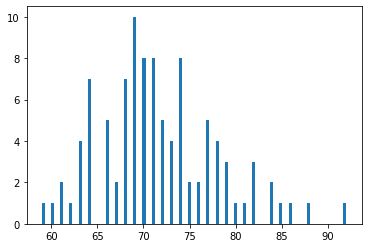

In [19]:
plt.hist(iter_terminate_list,100)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 2., 0., 1., 1., 0., 3., 0.,
        0., 1., 4., 4., 3., 1., 4., 2., 1., 4., 0., 2., 4., 3., 2., 3., 4.,
        2., 6., 2., 4., 3., 5., 6., 1., 2., 2., 5., 1., 2., 1., 1.]),
 array([0.99404623, 0.99410163, 0.99415703, 0.99421243, 0.99426783,
        0.99432323, 0.99437863, 0.99443403, 0.99448943, 0.99454483,
        0.99460023, 0.99465563, 0.99471103, 0.99476643, 0.99482183,
        0.99487724, 0.99493264, 0.99498804, 0.99504344, 0.99509884,
        0.99515424, 0.99520964, 0.99526504, 0.99532044, 0.99537584,
        0.99543124, 0.99548664, 0.99554204, 0.99559744, 0.99565284,
        0.99570824, 0.99576364, 0.99581904, 0.99587444, 0.99592984,
        0.99598524, 0.99604064, 0.99609605, 0.99615145, 0.99620685,
      

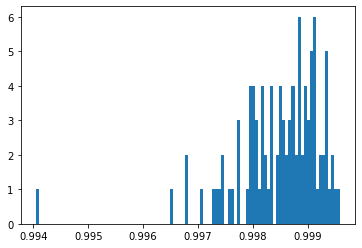

In [20]:
prb_last_list_real = [i.real for i in prb_last_list]
plt.hist(prb_last_list_real,100)

In [21]:
print('time now: ', end_time)

time now:  2022-11-27 12:14:11.447288


## 4 layers  (ing)

In [22]:
max_repeat = 100 #100
iter_max = 300  #300
num_of_layers = 4
prb_last_list = []
obj_list_rep = []
theta_list = []
iter_terminate_list = []
debug_flag, print_flag = 0, True
start_time = datetime.datetime.now()
for rep in range(1,max_repeat+1):
    if print_flag:
        print(f'\n\nrep={rep}')
    else:
        print(f'\n\nrep={rep}', end='  ')
    
    optimizer = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)
    theta=qml_np.random.uniform(0, 2*math.pi, size=(num_of_layers, 2*(num_of_qubits-1)), requires_grad=True)
    obj_list = []
    tiny_change_cnt = 0
    break_flag = False
    iter_terminate=iter_max
    for iter in range(1, iter_max+1):    
        theta, obj = optimizer.step_and_cost(objective_fn, theta)
#         val1_1 = quantum_circuit_with_HT(theta)
#         val1_2 = quantum_circuit_with_HTZ(theta)
#         val2 = quantum_circuit_no_HT_return_Z(theta)
        val1_1 = val_global[-1][0]
        val1_2 = val_global[-1][1]
#         val2 = val_global[-1][2]
        if iter>=2:
            val1_1_old = val_global[-2][0]
            val1_2_old = val_global[-2][1]
            val2_old = val_global[-2][2]
        else:
            val1_1_old = 999
            val1_2_old = 999
            val2_old = 999
        val1 = val1_1 - val1_2
        val1_old = val1_1_old - val1_2_old
        if abs(val1) > eps_val: # eps_val=1e-10
            if abs( (val1-val1_old)/val1 ) < tiny_change_threshold: # 1e-3
                tiny_change_cnt += 1
            else:
                tiny_change_cnt = 0
        if tiny_change_cnt >= cnt_threshold_no_change: # no change for a consequtive of 5 iterations, then break
            break_flag = True
        if (iter==1 or iter%20==0 or iter==iter_max) and print_flag:
            print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
                 :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}  \
                 :: theta={theta}')
#             print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
#                  :: val1_2={val1_2:12.8f} :: val2={val2:12.8f}  \
#                  coef2*val2-0.5*(val1_1 - val1_2)={coef2*val2-0.5*(val1_1 - val1_2):12.8f}  \
#                  :: theta={theta}')
            # print(f'iter={iter:3d} :: obj={obj:12.8f} :: theta={theta}')
        obj_list.append(obj)
        if break_flag:
            iter_terminate=iter
            break
    theta_list.append(theta)
    print(f'obj_list(last 3)={obj_list[-3:]}')
    obj_list_rep.append(obj_list)
    
    end_time = datetime.datetime.now()
    duration = end_time - start_time
    duration_in_s = duration.total_seconds()
    print(f'time consumed: {duration_in_s}s, after for-iter')
    
    print('val_global=')
    print(val_global)
    val_global = [] # reset to empty
    
    ## display the amplified state
    state = quantum_circuit_no_HT_return_state(theta)
    prb = [i.item()**2 for i in state]
    # print(f'state={state}')
    if len(prb)>20:
        print(f'prb(last 2)={prb[-2:]}')
    else: print(f'prb={prb}')
    iter_terminate_list.append(iter_terminate)
    prb_last_list.append(prb[-2])
# print('theta_list=', theta_list)
# print('iter_terminate_list=', iter_terminate_list)
# print('prb_last_list=', prb_last_list)
end_time = datetime.datetime.now()
duration = end_time - start_time
duration_in_s = duration.total_seconds()
print(f'time consumed: {duration_in_s}s')



rep=1
iter=  1 :: obj=  0.00296971 :: val1_1=  0.05855754                  :: val1_2=  0.06449697 :: -0.5*(val1_1 - val1_2)=  0.00296971                   :: theta=[[ 3.51207919  6.23502295  0.42468774  0.84682662  5.39805325  5.48312015
   4.01398662  3.35163659  2.09090219  0.42428563  5.80292116  0.54143514
   2.74226698  5.26316777  1.66856455  3.7937963   0.21418976  1.56579699
   0.42451904  4.28155409  3.6987019   3.48985046  2.39813367  5.8862176
   0.75696669  3.27957897  0.33101059  5.8580432   3.0112391   3.07755793]
 [ 5.89857477  5.76069901  3.14588456  4.58293115  0.43554851  5.18773338
   2.65613014  6.08870299  4.02815221  2.6458065   4.75615868  5.07554464
   6.04455949  1.37469544  3.53558502  1.63676612  3.74132578  1.60542792
   3.37573053  5.89341003  2.70026534  1.91164726  1.79325255  0.23331165
   0.12414142  0.57333514  4.00763326  3.70247784  1.60305987  2.71310638]
 [ 1.01424075  3.18533633  5.69008463  3.24497654  3.80730755  3.55837123
   5.01394828  5.02

In [23]:

print('theta_list=', theta_list)
print('iter_terminate_list=', iter_terminate_list)
print('prb_last_list=', prb_last_list)

theta_list= [tensor([[ 3.52052991,  6.2318209 ,  1.5953521 ,  0.74607256,  4.66370361,
          4.8745429 ,  4.62097335,  3.14084129,  1.58887338,  1.34963622,
          4.66849763,  0.86863576,  2.12790912,  5.24513386,  1.6198873 ,
          4.31677845, -0.52198658,  1.53990441, -0.96427613,  4.49019132,
          2.82552965,  2.93141713,  1.56665353,  6.76261654, -0.23691724,
          3.00427237,  0.69860786,  6.13264547,  3.59921187,  3.02888068],
        [ 4.73535959,  6.42782043,  4.21152861,  4.41655217,  1.53202171,
          4.63975655,  3.04777453,  4.80724525,  2.71139309,  2.91425916,
          4.62468767,  4.69804362,  5.8392704 ,  0.94642498,  3.39475155,
          1.42981674,  4.17038609,  0.70558201,  4.49899292,  5.073174  ,
          2.79760838,  1.68188999,  1.6371767 , -0.1467142 , -0.34775951,
          0.25781213,  4.39976049,  2.88356647,  2.20368617,  2.5722729 ],
        [ 1.54684708,  4.57375004,  4.33490218,  4.08137739,  4.78289257,
          2.86082197,  

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  4.,
         0.,  0.,  0.,  6.,  0.,  0.,  7.,  0.,  0.,  8.,  0.,  0.,  9.,
         0.,  0.,  6.,  0.,  0.,  0.,  9.,  0.,  0., 10.,  0.,  0., 11.,
         0.,  0.,  5.,  0.,  0.,  0.,  3.,  0.,  0.,  6.,  0.,  0.,  2.,
         0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([54.  , 54.31, 54.62, 54.93, 55.24, 55.55, 55.86, 56.17, 56.48,
        56.79, 57.1 , 57.41, 57.72, 58.03, 58.34, 58.65, 58.96, 59.27,
        59.58, 59.89, 60.2 , 60.51, 60.82, 61.13, 61.44, 61.75, 62.06,
        62.37, 62.68, 62.99, 63.3 , 63.61, 63.92, 64.23, 64.54, 64.85,
        65.16, 65.47, 65.78, 66.09, 66.4 , 66.71, 67.02, 67.33, 67.64,
        67.95, 68.26, 68.57, 68.88, 69.19, 69.5 , 69.81, 70.12, 70.43,
        

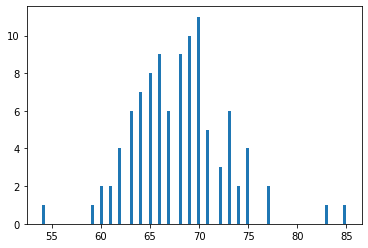

In [24]:
plt.hist(iter_terminate_list,100)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0.,
        1., 0., 1., 0., 0., 1., 3., 1., 0., 0., 3., 2., 2., 0., 0., 3., 0.,
        2., 2., 1., 2., 2., 2., 2., 3., 0., 4., 6., 1., 2., 5., 2., 8., 2.,
        6., 2., 4., 0., 3., 0., 3., 2., 1., 3., 2., 1., 2., 0., 1.]),
 array([0.99682128, 0.99684744, 0.9968736 , 0.99689976, 0.99692592,
        0.99695209, 0.99697825, 0.99700441, 0.99703057, 0.99705674,
        0.9970829 , 0.99710906, 0.99713522, 0.99716138, 0.99718755,
        0.99721371, 0.99723987, 0.99726603, 0.9972922 , 0.99731836,
        0.99734452, 0.99737068, 0.99739684, 0.99742301, 0.99744917,
        0.99747533, 0.99750149, 0.99752766, 0.99755382, 0.99757998,
        0.99760614, 0.9976323 , 0.99765847, 0.99768463, 0.99771079,
        0.99773695, 0.99776312, 0.99778928, 0.99781544, 0.9978416 ,
      

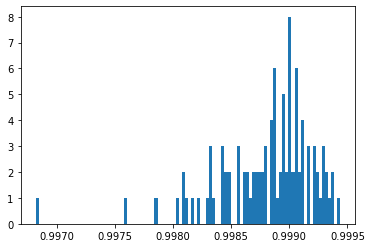

In [25]:
prb_last_list_real = [i.real for i in prb_last_list]
plt.hist(prb_last_list_real,100)

In [26]:
print('time now: ', end_time)

time now:  2022-11-27 22:28:25.555222


## 1 layers  (ing)

In [27]:
max_repeat = 100 #100
iter_max = 300  #300
num_of_layers = 1
prb_last_list = []
obj_list_rep = []
theta_list = []
iter_terminate_list = []
debug_flag, print_flag = 0, True
start_time = datetime.datetime.now()
for rep in range(1,max_repeat+1):
    if print_flag:
        print(f'\n\nrep={rep}')
    else:
        print(f'\n\nrep={rep}', end='  ')
    
    optimizer = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)
    theta=qml_np.random.uniform(0, 2*math.pi, size=(num_of_layers, 2*(num_of_qubits-1)), requires_grad=True)
    obj_list = []
    tiny_change_cnt = 0
    break_flag = False
    iter_terminate=iter_max
    for iter in range(1, iter_max+1):    
        theta, obj = optimizer.step_and_cost(objective_fn, theta)
#         val1_1 = quantum_circuit_with_HT(theta)
#         val1_2 = quantum_circuit_with_HTZ(theta)
#         val2 = quantum_circuit_no_HT_return_Z(theta)
        val1_1 = val_global[-1][0]
        val1_2 = val_global[-1][1]
#         val2 = val_global[-1][2]
        if iter>=2:
            val1_1_old = val_global[-2][0]
            val1_2_old = val_global[-2][1]
            val2_old = val_global[-2][2]
        else:
            val1_1_old = 999
            val1_2_old = 999
            val2_old = 999
        val1 = val1_1 - val1_2
        val1_old = val1_1_old - val1_2_old
        if abs(val1) > eps_val: # eps_val=1e-10
            if abs( (val1-val1_old)/val1 ) < tiny_change_threshold: # 1e-3
                tiny_change_cnt += 1
            else:
                tiny_change_cnt = 0
        if tiny_change_cnt >= cnt_threshold_no_change: # no change for a consequtive of 5 iterations, then break
            break_flag = True
        if (iter==1 or iter%20==0 or iter==iter_max) and print_flag:
            print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
                 :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}  \
                 :: theta={theta}')
#             print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
#                  :: val1_2={val1_2:12.8f} :: val2={val2:12.8f}  \
#                  coef2*val2-0.5*(val1_1 - val1_2)={coef2*val2-0.5*(val1_1 - val1_2):12.8f}  \
#                  :: theta={theta}')
            # print(f'iter={iter:3d} :: obj={obj:12.8f} :: theta={theta}')
        obj_list.append(obj)
        if break_flag:
            iter_terminate=iter
            break
    theta_list.append(theta)
    print(f'obj_list(last 3)={obj_list[-3:]}')
    obj_list_rep.append(obj_list)
    
    end_time = datetime.datetime.now()
    duration = end_time - start_time
    duration_in_s = duration.total_seconds()
    print(f'time consumed: {duration_in_s}s, after for-iter')
    
    print('val_global=')
    print(val_global)
    val_global = [] # reset to empty
    
    ## display the amplified state
    state = quantum_circuit_no_HT_return_state(theta)
    prb = [i.item()**2 for i in state]
    # print(f'state={state}')
    if len(prb)>20:
        print(f'prb(last 2)={prb[-2:]}')
    else: print(f'prb={prb}')
    iter_terminate_list.append(iter_terminate)
    prb_last_list.append(prb[-2])
# print('theta_list=', theta_list)
# print('iter_terminate_list=', iter_terminate_list)
# print('prb_last_list=', prb_last_list)
end_time = datetime.datetime.now()
duration = end_time - start_time
duration_in_s = duration.total_seconds()
print(f'time consumed: {duration_in_s}s')



rep=1
iter=  1 :: obj= -0.00011861 :: val1_1=  0.15470104                  :: val1_2=  0.15446382 :: -0.5*(val1_1 - val1_2)= -0.00011861                   :: theta=[[2.88345732 4.1956944  0.79633288 6.22660426 2.067187   1.34266665
  1.85998039 1.80349189 4.40274229 4.25305557 0.29527458 3.72806002
  4.6185572  4.98826596 5.41814066 1.26073051 5.34973047 2.20204152
  5.11854577 0.10579385 4.78919408 4.00278617 0.87309784 0.81066328
  4.1182427  3.42786507 3.49067387 2.20059941 3.17616004 3.50656338]]
iter= 20 :: obj= -0.56440332 :: val1_1=  0.44704121                  :: val1_2= -0.68176543 :: -0.5*(val1_1 - val1_2)= -0.56440332                   :: theta=[[ 3.68320996  3.62860338  1.68455379  5.30121603  2.97963599  2.23685868
   1.23295149  0.88796818  4.82856573  3.86349807  1.1749304   2.81918662
   3.74507625  5.6602446   4.9035844   0.38010781  5.15224545  3.11091154
   6.03319769 -0.82362496  5.30075838  3.45712354  1.79192144  0.0786251
   4.00937094  2.55788967  4.39982763  

In [28]:
print('theta_list=', theta_list)
print('iter_terminate_list=', iter_terminate_list)
print('prb_last_list=', prb_last_list)

theta_list= [tensor([[ 3.26526192e+00,  3.13176173e+00,  1.57643436e+00,
          4.88829580e+00,  3.58830027e+00,  3.12111964e+00,
          1.57266973e+00,  5.23409338e-01,  4.70575926e+00,
          3.56714694e+00,  1.26803480e+00,  3.12703775e+00,
          4.06553821e+00,  6.24673773e+00,  4.88447091e+00,
          1.22211667e-01,  4.70281167e+00,  3.14038776e+00,
          6.43408317e+00, -1.09732843e+00,  4.71677640e+00,
          3.14283311e+00,  2.07566441e+00, -3.63062267e-03,
          4.28711442e+00,  2.83893769e+00,  4.70976879e+00,
          6.58325359e-01,  1.60600590e+00,  2.97289364e+00]], requires_grad=True), tensor([[ 4.5094792 ,  3.13144156,  0.65092464,  6.28375519,  7.82203832,
          2.10843023,  1.5970804 ,  2.92371596,  2.54387318,  6.30581175,
          1.57374787,  1.7592732 ,  1.62783361,  6.35331878,  2.77899823,
          1.35002654,  4.70923861,  4.05931149,  1.57103766,  3.12420642,
          3.66639918,  3.17062227, -1.78345492,  2.18220253,  1.5706

(array([ 3.,  1.,  0.,  3.,  1.,  3.,  2.,  3.,  7.,  4.,  4., 12., 13.,
         4.,  5.,  3.,  5.,  1.,  1.,  1.,  3.,  2.,  0.,  2.,  0.,  1.,
         1.,  0.,  0.,  3.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 53.  ,  55.34,  57.68,  60.02,  62.36,  64.7 ,  67.04,  69.38,
         71.72,  74.06,  76.4 ,  78.74,  81.08,  83.42,  85.76,  88.1 ,
         90.44,  92.78,  95.12,  97.46,  99.8 , 102.14, 104.48, 106.82,
        109.16, 111.5 , 113.84, 116.18, 118.52, 120.86, 123.2 , 125.54,
        127.88, 130.22, 132.56, 134.9 , 137.24, 139.58, 141.92, 144.26,
        146.6 , 148.94, 151.28, 153.62, 155.96, 158.3 , 160.64, 162.98,
  

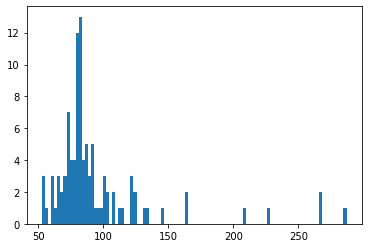

In [29]:
plt.hist(iter_terminate_list,100)

(array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  4., 85.]),
 array([9.16863587e-05, 1.00866290e-02, 2.00815716e-02, 3.00765142e-02,
        4.00714568e-02, 5.00663994e-02, 6.00613420e-02, 7.00562846e-02,
        8.00512272e-02, 9.00461698e-02, 1.00041112e-01, 1.10036055e-01,
        1.20030998e-01, 1.30025940e-01, 1.40020883e-01, 1.50015825e-01,
        1.60010768e-01, 1.70005711e-01, 1.80000653e-01, 1.89995596e-01,
        1.99990539e-01, 2.09985481e-01, 2.19980424e-01, 2.29975366e-01,
  

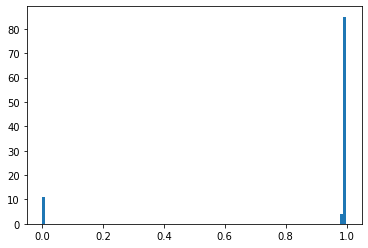

In [30]:
prb_last_list_real = [i.real for i in prb_last_list]
plt.hist(prb_last_list_real,100)

In [31]:
print('time now: ', end_time)

time now:  2022-11-28 01:57:56.852306


## 1 layers (from another file)
- the code and results below are from VAA_i3_2cir_brk_q15_struct3_1L.ipynb

In [12]:
max_repeat = 100 #100
iter_max = 300  #300
num_of_layers = 1
prb_last_list = []
obj_list_rep = []
theta_list = []
iter_terminate_list = []
debug_flag, print_flag = 0, True
start_time = datetime.datetime.now()
for rep in range(1,max_repeat+1):
    if print_flag:
        print(f'\n\nrep={rep}')
    else:
        print(f'\n\nrep={rep}', end='  ')
    
    optimizer = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)
    theta=qml_np.random.uniform(0, 2*math.pi, size=(num_of_layers, 2*(num_of_qubits-1)), requires_grad=True)
    obj_list = []
    tiny_change_cnt = 0
    break_flag = False
    iter_terminate=iter_max
    for iter in range(1, iter_max+1):    
        theta, obj = optimizer.step_and_cost(objective_fn, theta)
#         val1_1 = quantum_circuit_with_HT(theta)
#         val1_2 = quantum_circuit_with_HTZ(theta)
#         val2 = quantum_circuit_no_HT_return_Z(theta)
        val1_1 = val_global[-1][0]
        val1_2 = val_global[-1][1]
#         val2 = val_global[-1][2]
        if iter>=2:
            val1_1_old = val_global[-2][0]
            val1_2_old = val_global[-2][1]
            val2_old = val_global[-2][2]
        else:
            val1_1_old = 999
            val1_2_old = 999
            val2_old = 999
        val1 = val1_1 - val1_2
        val1_old = val1_1_old - val1_2_old
        if abs(val1) > eps_val: # eps_val=1e-10
            if abs( (val1-val1_old)/val1 ) < tiny_change_threshold: # 1e-3
                tiny_change_cnt += 1
            else:
                tiny_change_cnt = 0
        if tiny_change_cnt >= cnt_threshold_no_change: # no change for a consequtive of 5 iterations, then break
            break_flag = True
        if (iter==1 or iter%20==0 or iter==iter_max) and print_flag:
            print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
                 :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}  \
                 :: theta={theta}')
#             print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
#                  :: val1_2={val1_2:12.8f} :: val2={val2:12.8f}  \
#                  coef2*val2-0.5*(val1_1 - val1_2)={coef2*val2-0.5*(val1_1 - val1_2):12.8f}  \
#                  :: theta={theta}')
            # print(f'iter={iter:3d} :: obj={obj:12.8f} :: theta={theta}')
        obj_list.append(obj)
        if break_flag:
            iter_terminate=iter
            break
    theta_list.append(theta)
    print(f'obj_list(last 3)={obj_list[-3:]}')
    obj_list_rep.append(obj_list)
    
    end_time = datetime.datetime.now()
    duration = end_time - start_time
    duration_in_s = duration.total_seconds()
    print(f'time consumed: {duration_in_s}s, after for-iter')
    
    print('val_global=')
    print(val_global)
    val_global = [] # reset to empty
    
    ## display the amplified state
    state = quantum_circuit_no_HT_return_state(theta)
    prb = [i.item()**2 for i in state]
    # print(f'state={state}')
    if len(prb)>20:
        print(f'prb(last 2)={prb[-2:]}')
    else: print(f'prb={prb}')
    iter_terminate_list.append(iter_terminate)
    prb_last_list.append(prb[-2])
# print('theta_list=', theta_list)
# print('iter_terminate_list=', iter_terminate_list)
# print('prb_last_list=', prb_last_list)
end_time = datetime.datetime.now()
duration = end_time - start_time
duration_in_s = duration.total_seconds()
print(f'time consumed: {duration_in_s}s')



rep=1
iter=  1 :: obj=  0.00000998 :: val1_1=  0.00883578                  :: val1_2=  0.00885575 :: -0.5*(val1_1 - val1_2)=  0.00000998                   :: theta=[[5.25238953 4.26929723 3.85017863 4.05786309 4.81830932 5.67736647
  2.66753384 3.06011392 4.7229261  3.15947844 3.88215206 0.7486401
  5.81385504 6.01150061 5.75565087 4.77830053 2.74000924 1.65259135
  3.19502953 6.12660601 5.55035392 2.46444101 1.36051129 4.28122151
  1.71185126 3.44897196 1.82423772 2.08555374 6.07806352 0.91352326]]
iter= 20 :: obj= -0.00279718 :: val1_1=  0.01147144                  :: val1_2=  0.00587709 :: -0.5*(val1_1 - val1_2)= -0.00279718                   :: theta=[[ 5.71553909  4.88612129  2.97259586  3.3503176   3.94572953  6.13260228
   1.98827379  3.4232504   5.5084466   3.5910635   4.72983939 -0.09795127
   4.95009949  6.91112598  6.60409983  5.28183547  1.94260589  1.00145945
   2.9488723   6.3672204   6.00717467  1.58850731  2.06644401  4.0048138
   1.01692718  4.25303103  2.14172059  1

In [13]:
print('theta_list=', theta_list)
print('iter_terminate_list=', iter_terminate_list)
print('prb_last_list=', prb_last_list)

theta_list= [tensor([[ 5.09128265,  6.32108733,  4.65348255,  3.90170825,  4.76764069,
          5.99846728,  1.47733272,  3.13796469,  7.94047081,  5.92043544,
          5.81157032, -0.02189715,  4.74523304,  8.75602365,  6.33921676,
          4.34704282,  1.55383901, -0.04302431,  3.96632451,  6.23382363,
          8.14159643,  3.06332309,  4.68242733,  3.0574324 ,  1.21453704,
          5.17159755,  1.5801393 ,  0.03959778,  5.39753196,  1.49708915]], requires_grad=True), tensor([[ 8.42831367e-01, -1.95517947e-03, -3.95790591e-01,
         -1.34042740e-02,  4.74381111e+00, -3.27517046e-01,
          2.51298546e+00,  3.14259925e+00,  5.30531106e+00,
          3.14372803e+00,  7.88045063e+00,  6.61827395e+00,
          5.48074919e+00,  6.24901121e+00,  2.88861575e+00,
          2.27466620e+00,  1.56998137e+00, -1.17636313e+00,
          1.58088343e+00, -3.07359182e-02,  1.89631255e+00,
          4.09660412e+00,  4.71235706e+00,  5.88940898e-01,
          4.71034062e+00,  3.11630095e+0

(array([ 2.,  1.,  2.,  2.,  5.,  8.,  6., 12., 11., 11.,  5.,  6.,  5.,
         2.,  2.,  2.,  0.,  5.,  2.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 59.  ,  61.41,  63.82,  66.23,  68.64,  71.05,  73.46,  75.87,
         78.28,  80.69,  83.1 ,  85.51,  87.92,  90.33,  92.74,  95.15,
         97.56,  99.97, 102.38, 104.79, 107.2 , 109.61, 112.02, 114.43,
        116.84, 119.25, 121.66, 124.07, 126.48, 128.89, 131.3 , 133.71,
        136.12, 138.53, 140.94, 143.35, 145.76, 148.17, 150.58, 152.99,
        155.4 , 157.81, 160.22, 162.63, 165.04, 167.45, 169.86, 172.27,
  

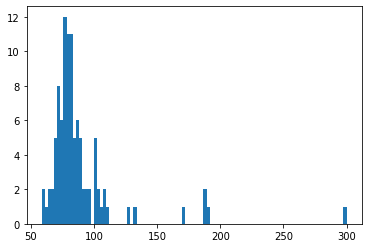

In [14]:
plt.hist(iter_terminate_list,100)

(array([14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 86.]),
 array([7.31650503e-15, 9.99714878e-03, 1.99942976e-02, 2.99914463e-02,
        3.99885951e-02, 4.99857439e-02, 5.99828927e-02, 6.99800414e-02,
        7.99771902e-02, 8.99743390e-02, 9.99714878e-02, 1.09968637e-01,
        1.19965785e-01, 1.29962934e-01, 1.39960083e-01, 1.49957232e-01,
        1.59954380e-01, 1.69951529e-01, 1.79948678e-01, 1.89945827e-01,
        1.99942976e-01, 2.09940124e-01, 2.19937273e-01, 2.29934422e-01,
  

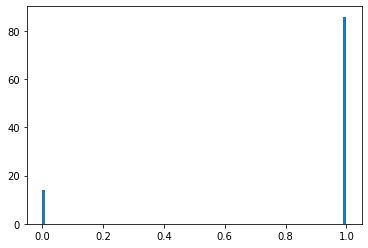

In [15]:
prb_last_list_real = [i.real for i in prb_last_list]
plt.hist(prb_last_list_real,100)

In [16]:
print('time now: ', end_time)

time now:  2022-11-27 09:44:17.313087


# 3rd last flipped

In [34]:

N = 2**(num_of_qubits-2)
normal_val = math.sqrt(1/N)
# initial_state_phi1 = [math.sqrt(1/N)]*(N-1) + [0]*N + [math.sqrt(1/N)] # 2**(num_of_qubits-1)
# initial_state_phi1 = [.5,.5,.5, 0,   0, 0, 0, .5,  ] # 2**(num_of_qubits-1)

initial_state3 = [1/math.sqrt(N)]*(N-3) + [0, 1/math.sqrt(N), 1/math.sqrt(N)] + [0]*(N-3) + [1/math.sqrt(N), 0, 0] # 2**(num_qubits-1)
initial_state_phi1 = initial_state3
print(f'initial_state_phi1={initial_state_phi1}')
# print(f'initial_state_phi1={initial_state_phi1[-5:]}')
initial_state_0_phi1  = initial_state_phi1 + [0]*len(initial_state_phi1) # 2**num_of_qubits


# print(f'initial_state3={initial_state3}')
# initial_state  = initial_state3 + [0]*len(initial_state3) # 2**num_qubits

initial_state_phi1=[0.5, 0, 0.5, 0.5, 0, 0.5, 0, 0]


In [35]:
device_name = 'default.qubit'  #'default.qubit' # 
device_name2 = 'default.qubit' # has qml.state()

In [36]:
print('time now: ', end_time)

time now:  2022-11-23 23:18:48.718498
